<a href="https://colab.research.google.com/github/sclaudiobr/algoritmos-py/blob/master/GeoCloud02_Mapas_Tematicos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

,id,objectid,cd_fcim,leg_carga,clas_domi,leg_uveg,nm_uveg,leg_uantr,nm_uantr,leg_contat,nm_contat,veg_pretet,nm_pretet,leg_sec1,nm_sec1,leg_sec2,nm_sec2,leg_sup,legenda,ar_poli_km,geometry
0,vegetacao_area_brasil.140651,140651,SH22,Iu.C,Iu,None,None,Iu,Influência urbana,None,None,C,Floresta Estacional Decidual,None,None,None,None,Área Antrópica Dominante,3Iu - Influência urbana,48.0916,"POLYGON ((-53.82216 -29.66397, -53.82082 -29.6..."
1,vegetacao_area_brasil.136828,136828,SH21,Ag.E,Ag,None,None,Ag,Agropecuária,None,None,E,Estepe,None,None,None,None,Área Antrópica Dominante,3Ag - Agropecuária,4925.2775,"MULTIPOLYGON (((-54.00000 -29.63772, -54.00000..."
2,vegetacao_area_brasil.142827,142827,SH22,000Magua,Magua,None,None,None,None,None,None,None,None,None,None,None,None,Massa D´água,5Corpo d´água continental,0.0768,"POLYGON ((-53.74861 -29.86287, -53.74935 -29.8..."
3,vegetacao_area_brasil.142598,142598,SH22,000Magua,Magua,None,None,None,None,None,None,None,None,None,None,None,None,Massa D´água,5Corpo d´água continental,0.1164,"POLYGON ((-53.83139 -29.77746, -53.83153 -29.7..."
4,vegetacao_area_brasil.138544,138544,SH21,000Magua,Magua,None,None,None,None,None,None,None,None,None,None,None,None,Massa D´água,5Corpo d´água continental,0.0811,"POLYGON ((-54.02988 -29.65965, -54.02995 -29.6..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,vegetacao_area_brasil.141360,141360,SH22,Ag.NM,Ag,None,None,Ag,Agropecuária,NM,Contato Floresta Estacional/Floresta Ombrófila...,NM,Contato Floresta Estacional/Floresta Ombrófila...,None,None,None,None,Área Antrópica Dominante em Tensão Ecológica,4Ag - Agropecuária,40.8176,"POLYGON ((-53.51959 -29.72802, -53.52158 -29.7..."
119,vegetacao_area_brasil.141406,141406,SH22,Ag.EM,Ag,None,None,Ag,Agropecuária,EM,Contato Estepe/Floresta Ombrófila Mista,EM,Contato Estepe/Floresta Ombrófila Mista,None,None,None,None,Área Antrópica Dominante em Tensão Ecológica,4Ag - Agropecuária,661.6061,"POLYGON ((-53.64724 -29.59654, -53.64710 -29.5..."
120,vegetacao_area_brasil.141412,141412,SH22,Ag.EN,Ag,None,None,Ag,Agropecuária,EN,Contato Estepe/Floresta Estacional,EN,Contato Estepe/Floresta Estacional,None,None,None,None,Área Antrópica Dominante em Tensão Ecológica,4Ag - Agropecuária,274.4553,"MULTIPOLYGON (((-53.73830 -29.70038, -53.73773..."
121,vegetacao_area_brasil.141436,141436,SH22,Ag.EN,Ag,None,None,Ag,Agropecuária,EN,Contato Estepe/Floresta Estacional,EN,Contato Estepe/Floresta Estacional,None,None,None,None,Área Antrópica Dominante em Tensão Ecológica,4Ag - Agropecuária,19.6400,"POLYGON ((-53.53674 -29.73275, -53.53290 -29.7..."


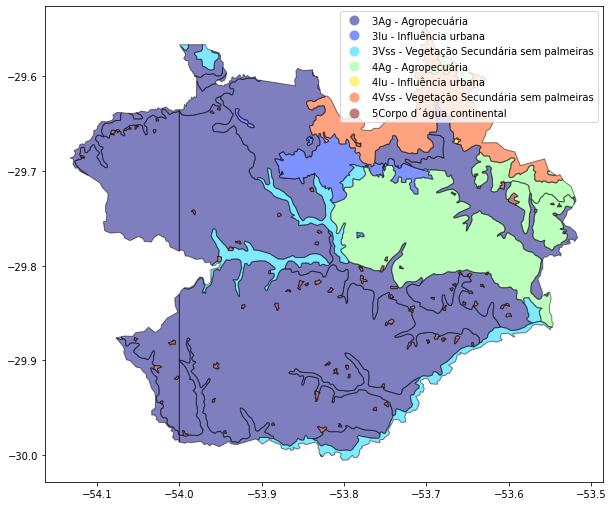

In [6]:
!pip install geobr # Base de dados do IBGE, Malahas municipais, biomas, microrregiões, sedes
!pip install shapely # conversor e leitor de arquivos shp 
!pip install OWSLib # Acesso ao banco de dados WFS/WMS/OWS
!pip install pygeos # Biblioteca de apoio ao Geopandas
import numpy as np
import geobr as br
import geopandas as gpd
import os
import owslib.wfs as ows
from owslib.wfs import WebFeatureService
from shapely.geometry import box
import zipfile

os.mkdir("shp")

### ----------------------- FUNÇÂO BAIXAR DADOS -----------------------------
def gera_dados(uf,mun,id):
   df = br.read_municipality(code_muni=uf)
   df = df[df.name_muni==mun]
   #df.to_file('sm.geojson', driver='GeoJSON')
   dfbox = box(*df.total_bounds).bounds
   latitude,longitude = np.array(dfbox)[1],np.array(dfbox)[2]
   wfs_url = 'https://geoservicos.ibge.gov.br/geoserver/wfs'
   # Conectando ao serviço do GeoServer WFS.
   wfs = WebFeatureService(wfs_url, version='2.0.0')
   data = wfs.getfeature(typename=id, bbox=dfbox, outputFormat='JSON')
   fn = 'df.geojson'
   with open(fn, 'wb') as fh:
      fh.write(data.read())
   layers = gpd.read_file(fn)
   recorte = gpd.clip(layers, df,keep_geom_type=False)
   recorte.to_file('shp/df.shp', driver='ESRI Shapefile')
### ----------------- UF, MUNICIPIO, TEMA


# Compacta a pasta com o nome do ID escolhido
def zip(src, dst):
    zf = zipfile.ZipFile("%s.zip" % (dst), "w", zipfile.ZIP_DEFLATED)
    abs_src = os.path.abspath(src)
    for dirname, subdirs, files in os.walk(src):
        for filename in files:
            absname = os.path.abspath(os.path.join(dirname, filename))
            arcname = absname[len(abs_src) + 1:]
            print('zipping %s as %s' % (os.path.join(dirname, filename), arcname))
            zf.write(absname, arcname)
    zf.close()



# Identficadores
geo = 'CREN:Geologia_area_Brasil'
geom = 'CREN:brasil_geom_area'
ped = 'CREN:Pedologia_area_Brasil'
veg = 'CREN:vegetacao_area_brasil'

#### TROCA OS DADOS AQUI ########################
UF = 'RS' # <---- Estado aqui
mun = 'Santa Maria' #<--- Municipio Aqui (nome com acentuação)
nome_do_zip = 'vegetacao' # <- Troca aqui Aqui (nome sem acento)
#############################################
gera_dados(UF,mun,veg)
zip("projeto",nome_do_zip)

# Plotando o mapa
gdf =gpd.read_file('shp/df.shp')
gdf.plot(figsize=(10,10), alpha=0.5, edgecolor='k', cmap="jet",column='legenda', legend=True)
gdf